In [1]:
import numpy as np

# Importing standard Qiskit libraries
from qiskit import QuantumCircuit, transpile, Aer, IBMQ
from qiskit.tools.jupyter import *
from qiskit.visualization import *
from ibm_quantum_widgets import *
from qiskit.providers.aer import QasmSimulator

# Loading your IBM Quantum account(s)
provider = IBMQ.load_account()
provider.has_service('runtime')

True

In [2]:
# useful additional packages
import matplotlib.pyplot as plt
import matplotlib.axes as axes
%matplotlib inline
import numpy as np
import networkx as nx

from qiskit import Aer
from qiskit.tools.visualization import plot_histogram
from qiskit.circuit.library import TwoLocal
from qiskit_optimization.applications import Maxcut, Tsp
from qiskit.algorithms import VQE, NumPyMinimumEigensolver
from qiskit.algorithms.optimizers import SPSA,COBYLA
from qiskit.utils import algorithm_globals
from qiskit.utils import QuantumInstance
from qiskit_optimization.algorithms import MinimumEigenOptimizer
from qiskit_optimization.problems import QuadraticProgram

import requests
import json
import time

distance
 [[ 0. 48. 91.]
 [48.  0. 63.]
 [91. 63.  0.]]


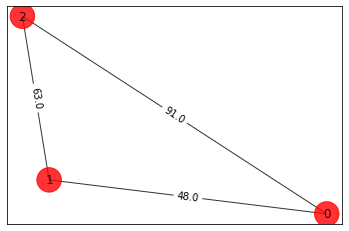

In [3]:
#node = 3
n = 3
num_qubits = n ** 2
tsp = Tsp.create_random_instance(n, seed=123)
adj_matrix = nx.to_numpy_matrix(tsp.graph)
print('distance\n', adj_matrix)

colors = ['r' for node in tsp.graph.nodes]
pos = [tsp.graph.nodes[node]['pos']  for node in tsp.graph.nodes]
def draw_graph(G, colors, pos):
    default_axes = plt.axes(frameon=True)
    nx.draw_networkx(G, node_color=colors, node_size=600, alpha=.8, ax=default_axes, pos=pos)
    edge_labels = nx.get_edge_attributes(G, 'weight')
    nx.draw_networkx_edge_labels(G, pos=pos, edge_labels=edge_labels)
draw_graph(tsp.graph, colors, pos)

order = (0, 1, 2) Distance = 202.0
Best order from brute force = (0, 1, 2) with total distance = 202.0


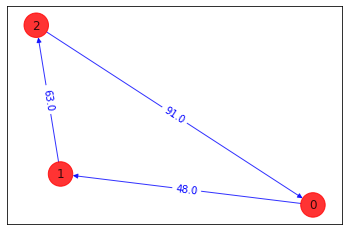

In [4]:
#brute force method
from itertools import permutations

def brute_force_tsp(w, N):
    a = list(permutations(range(1,N)))
    last_best_distance = 1e10
    for i in a:
        distance = 0
        pre_j = 0
        for j in i:
            distance = distance + w[j,pre_j]
            pre_j = j
        distance = distance + w[pre_j,0]
        order = (0,) + i
        if distance < last_best_distance:
            best_order = order
            last_best_distance = distance
            print('order = ' + str(order) + ' Distance = ' + str(distance))
    return last_best_distance, best_order
  
best_distance, best_order = brute_force_tsp(adj_matrix , n)
print('Best order from brute force = ' + str(best_order) + ' with total distance = ' + str(best_distance))

def draw_tsp_solution(G, order, colors, pos):
    G2 = nx.DiGraph()
    G2.add_nodes_from(G)
    n = len(order)
    for i in range(n):
        j = (i + 1) % n
        G2.add_edge(order[i], order[j], weight=G[order[i]][order[j]]['weight'])
    default_axes = plt.axes(frameon=True)
    nx.draw_networkx(G2, node_color=colors, edge_color='b', node_size=600, alpha=.8, ax=default_axes, pos=pos)
    edge_labels = nx.get_edge_attributes(G2, 'weight')
    nx.draw_networkx_edge_labels(G2, pos, font_color='b', edge_labels=edge_labels)
    
draw_tsp_solution(tsp.graph, best_order, colors, pos)

In [5]:
#creating the quadratic program
qp = tsp.to_quadratic_program()
print(qp.export_as_lp_string())

\ This file has been generated by DOcplex
\ ENCODING=ISO-8859-1
\Problem name: TSP

Minimize
 obj: [ 96 x_0_0*x_1_1 + 96 x_0_0*x_1_2 + 182 x_0_0*x_2_1 + 182 x_0_0*x_2_2
      + 96 x_0_1*x_1_0 + 96 x_0_1*x_1_2 + 182 x_0_1*x_2_0 + 182 x_0_1*x_2_2
      + 96 x_0_2*x_1_0 + 96 x_0_2*x_1_1 + 182 x_0_2*x_2_0 + 182 x_0_2*x_2_1
      + 126 x_1_0*x_2_1 + 126 x_1_0*x_2_2 + 126 x_1_1*x_2_0 + 126 x_1_1*x_2_2
      + 126 x_1_2*x_2_0 + 126 x_1_2*x_2_1 ]/2
Subject To
 c0: x_0_0 + x_0_1 + x_0_2 = 1
 c1: x_1_0 + x_1_1 + x_1_2 = 1
 c2: x_2_0 + x_2_1 + x_2_2 = 1
 c3: x_0_0 + x_1_0 + x_2_0 = 1
 c4: x_0_1 + x_1_1 + x_2_1 = 1
 c5: x_0_2 + x_1_2 + x_2_2 = 1

Bounds
 0 <= x_0_0 <= 1
 0 <= x_0_1 <= 1
 0 <= x_0_2 <= 1
 0 <= x_1_0 <= 1
 0 <= x_1_1 <= 1
 0 <= x_1_2 <= 1
 0 <= x_2_0 <= 1
 0 <= x_2_1 <= 1
 0 <= x_2_2 <= 1

Binaries
 x_0_0 x_0_1 x_0_2 x_1_0 x_1_1 x_1_2 x_2_0 x_2_1 x_2_2
End



In [6]:
from qiskit_optimization.converters import QuadraticProgramToQubo

qp2qubo = QuadraticProgramToQubo()
qubo = qp2qubo.convert(qp)
qubitOp, offset = qubo.to_ising()
print('Offset:', offset)
print('Ising Hamiltonian:')
print(str(qubitOp))

Offset: 7581.0
Ising Hamiltonian:
-1290.0 * ZIIIIIIII
- 1290.0 * IZIIIIIII
+ 606.5 * ZZIIIIIII
- 1290.0 * IIZIIIIII
+ 606.5 * ZIZIIIIII
+ 606.5 * IZZIIIIII
- 1268.5 * IIIZIIIII
+ 606.5 * ZIIZIIIII
+ 15.75 * IZIZIIIII
+ 15.75 * IIZZIIIII
- 1268.5 * IIIIZIIII
+ 15.75 * ZIIIZIIII
+ 606.5 * IZIIZIIII
+ 15.75 * IIZIZIIII
+ 606.5 * IIIZZIIII
- 1268.5 * IIIIIZIII
+ 15.75 * ZIIIIZIII
+ 15.75 * IZIIIZIII
+ 606.5 * IIZIIZIII
+ 606.5 * IIIZIZIII
+ 606.5 * IIIIZZIII
- 1282.5 * IIIIIIZII
+ 606.5 * ZIIIIIZII
+ 22.75 * IZIIIIZII
+ 22.75 * IIZIIIZII
+ 606.5 * IIIZIIZII
+ 12.0 * IIIIZIZII
+ 12.0 * IIIIIZZII
- 1282.5 * IIIIIIIZI
+ 22.75 * ZIIIIIIZI
+ 606.5 * IZIIIIIZI
+ 22.75 * IIZIIIIZI
+ 12.0 * IIIZIIIZI
+ 606.5 * IIIIZIIZI
+ 12.0 * IIIIIZIZI
+ 606.5 * IIIIIIZZI
- 1282.5 * IIIIIIIIZ
+ 22.75 * ZIIIIIIIZ
+ 22.75 * IZIIIIIIZ
+ 606.5 * IIZIIIIIZ
+ 12.0 * IIIZIIIIZ
+ 12.0 * IIIIZIIIZ
+ 606.5 * IIIIIZIIZ
+ 606.5 * IIIIIIZIZ
+ 606.5 * IIIIIIIZZ


In [7]:
exact = MinimumEigenOptimizer(NumPyMinimumEigensolver())
result = exact.solve(qubo)
print(result)

optimal function value: 202.0
optimal value: [1. 0. 0. 0. 1. 0. 0. 0. 1.]
status: SUCCESS


energy: -7379.0
tsp objective: 202.0
feasible: True
solution: [0, 1, 2]
solution objective: 202.0


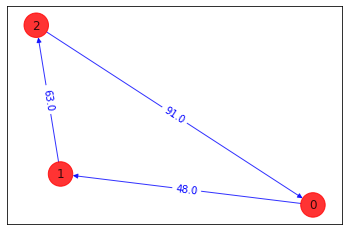

In [8]:

#Making the Hamiltonian in its full form and getting the lowest eigenvalue and eigenvector
ee = NumPyMinimumEigensolver()
result = ee.compute_minimum_eigenvalue(qubitOp)

print('energy:', result.eigenvalue.real)
print('tsp objective:', result.eigenvalue.real + offset)
x = tsp.sample_most_likely(result.eigenstate)
print('feasible:', qubo.is_feasible(x))
z = tsp.interpret(x)
print('solution:', z)
print('solution objective:', tsp.tsp_value(z, adj_matrix))
draw_tsp_solution(tsp.graph, z, colors, pos)

In [9]:
#calling the statevector as backend
algorithm_globals.random_seed = 123
seed = 10598
backend = Aer.get_backend('statevector_simulator')
quantum_instance = QuantumInstance(backend, seed_simulator=seed, seed_transpiler=seed)

energy: -6229.640151617039
time: 5.546398162841797
feasible: True
solution: [2, 1, 0]
solution objective: 202.0


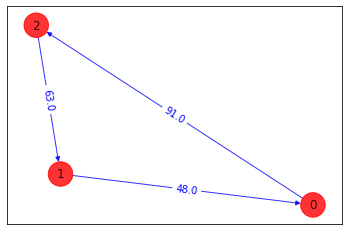

In [11]:
#here optimizer used is spsa, ry is the ansatz
spsa = SPSA(maxiter=300)
ry = TwoLocal(qubitOp.num_qubits, 'ry', 'cz', reps=5, entanglement='linear')
vqe = VQE(ry, optimizer=spsa, quantum_instance=quantum_instance)

result = vqe.compute_minimum_eigenvalue(qubitOp)

print('energy:', result.eigenvalue.real)
print('time:', result.optimizer_time)
x = tsp.sample_most_likely(result.eigenstate)
print('feasible:', qubo.is_feasible(x))
z = tsp.interpret(x)
print('solution:', z)
print('solution objective:', tsp.tsp_value(z, adj_matrix))
draw_tsp_solution(tsp.graph, z, colors, pos)

optimal function value: 202.0
optimal value: [1. 0. 0. 0. 0. 1. 0. 1. 0.]
status: SUCCESS
solution: [2, 1, 0]
solution objective: 202.0


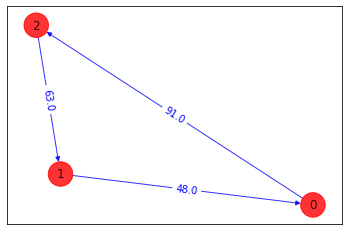

In [12]:
# create minimum eigen optimizer based on VQE
import warnings
warnings.filterwarnings('ignore', category=UserWarning)
vqe_optimizer = MinimumEigenOptimizer(vqe)

# solve quadratic program
result = vqe_optimizer.solve(qp)
print(result)

z = tsp.interpret(x)
print('solution:', z)
print('solution objective:', tsp.tsp_value(z, adj_matrix))
draw_tsp_solution(tsp.graph, z, colors, pos)

In [13]:
from qiskit.circuit.library import EfficientSU2

spsa = SPSA(maxiter=300)
ry = EfficientSU2(qubitOp.num_qubits, su2_gates=['ry', 'cz'], entanglement='linear', reps=5)
print(ry)

     ┌──────────┐        ┌──────────┐                                       »
q_0: ┤ Ry(θ[0]) ├─■───■──┤ Ry(θ[9]) ├───────────────────■────────────■──────»
     ├──────────┤ │ ┌─┴─┐└──────────┘┌───────────┐      │          ┌─┴─┐    »
q_1: ┤ Ry(θ[1]) ├─■─┤ X ├─────■──────┤ Ry(θ[10]) ├──────■──────────┤ X ├────»
     ├──────────┤   └───┘   ┌─┴─┐    └───────────┘┌───────────┐    └───┘    »
q_2: ┤ Ry(θ[2]) ├─■─────────┤ X ├──────────■──────┤ Ry(θ[11]) ├─────────────»
     ├──────────┤ │         └───┘        ┌─┴─┐    └───────────┘┌───────────┐»
q_3: ┤ Ry(θ[3]) ├─■──────────────────────┤ X ├──────────■──────┤ Ry(θ[12]) ├»
     ├──────────┤                        └───┘        ┌─┴─┐    └───────────┘»
q_4: ┤ Ry(θ[4]) ├─■───────────────────────────────────┤ X ├──────────■──────»
     ├──────────┤ │                                   └───┘        ┌─┴─┐    »
q_5: ┤ Ry(θ[5]) ├─■────────────────────────────────────────────────┤ X ├────»
     ├──────────┤                                               

<ipython-input-14-63b7181f8eb0>:2: DeprecationWarning: The QuantumCircuit.__iadd__() method is being deprecated. Use the compose() (potentially with the inplace=True argument) and tensor() methods which are more flexible w.r.t circuit register compatibility.
  qc += ry
/opt/conda/lib/python3.8/site-packages/qiskit/circuit/quantumcircuit.py:942: DeprecationWarning: The QuantumCircuit.extend() method is being deprecated. Use the compose() (potentially with the inplace=True argument) and tensor() methods which are more flexible w.r.t circuit register compatibility.
  return self.extend(rhs)


Figure(1591.6x1167.88)


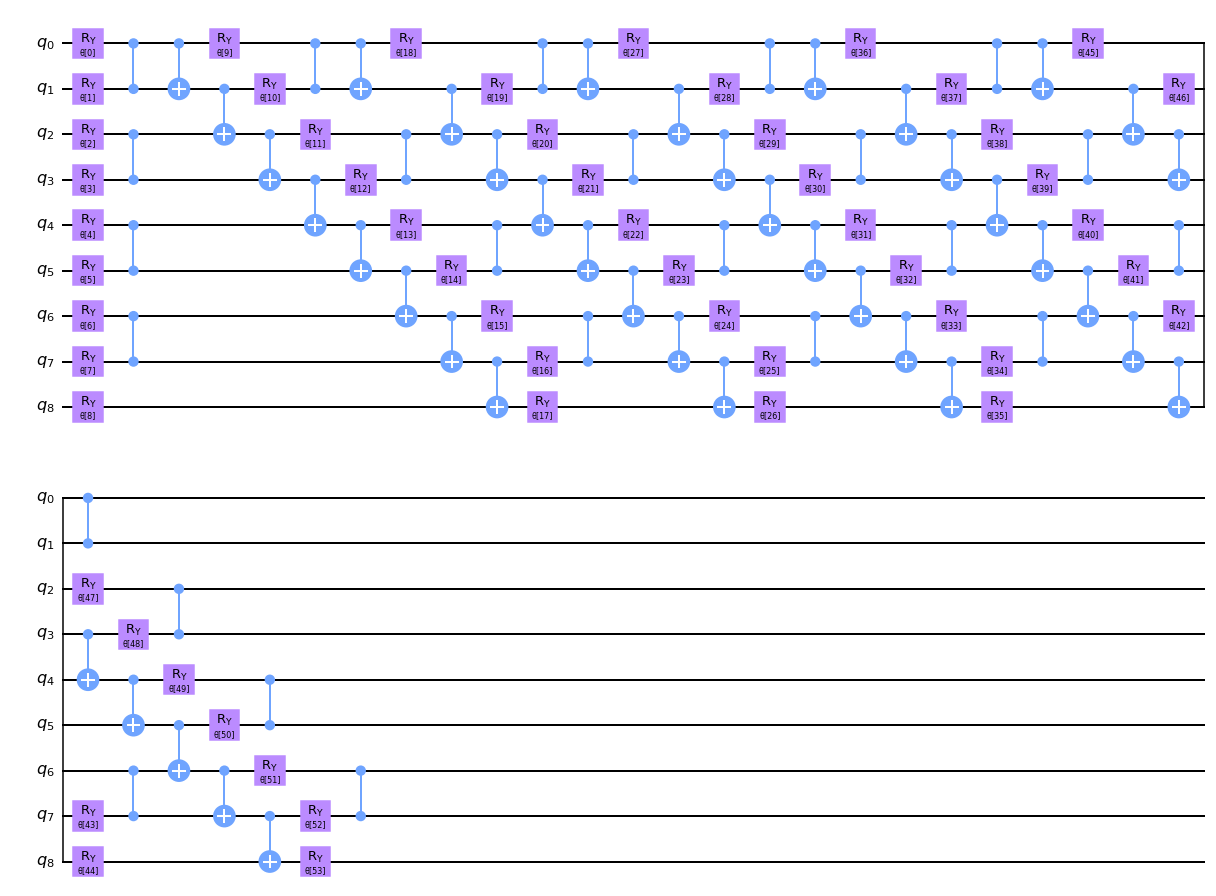

In [14]:
qc = QuantumCircuit(qubitOp.num_qubits)
qc += ry
print(qc.decompose().draw())

In [15]:
#calling the runtime api
my_api_key='insert your API key here'
headers = {
  'Authorization': f'Bearer {my_api_key}',
  'Content-Type': 'application/json'
}

Runtime_API_URL = "https://runtime-us-east.quantum-computing.ibm.com/"

In [16]:
ansatz = ry

np.random.seed(10)  # seed for reproducibility
initial_point = np.random.random(ansatz.num_parameters)

In [17]:
from qiskit import IBMQ

IBMQ.load_account()
provider = IBMQ.get_provider()  # replace by your designated provider


ibmqfactory.load_account:WARNING:2021-08-30 19:34:30,986: Credentials are already in use. The existing account in the session will be replaced.


In [18]:
backend = provider.get_backend('ibmq_qasm_simulator')


In [19]:
intermediate_info = {
    'nfev': [],
    'parameters': [],
    'energy': [],
    'stddev': []
}

def callback(nfev, parameters, energy, stddev):
    intermediate_info['nfev'].append(nfev)
    intermediate_info['parameters'].append(parameters)
    intermediate_info['energy'].append(energy)
    intermediate_info['stddev'].append(stddev)

In [20]:
measurement_error_mitigation = True

from qiskit_nature.runtime import VQEProgram

# in this first release, the optimizer must be specified as dictionary
optimizer = {'name': 'SPSA',
             'maxiter': 300}

runtime_vqe = VQEProgram(ansatz=qc,
                         optimizer=optimizer,
                         provider=provider,
                         backend=backend,
                         shots=100,
                         measurement_error_mitigation=measurement_error_mitigation,
                         callback=callback)

In [21]:
runtime_result = runtime_vqe.compute_minimum_eigenvalue(qubitOp)

In [29]:

print('Eigenvalue:', runtime_result.eigenvalue)
print('Mean error:', np.mean(intermediate_info['stddev']))
print(runtime_result)

Eigenvalue: (-3109.5699318382776+0j)
Mean error: nan
{   'aux_operator_eigenvalues': None,
    'cost_function_evals': 600,
    'eigenstate': {   '000000001': 1.708928451493871e-10,
                      '000000101': 8.572647751850482e-11,
                      '000010000': 0.17320507973724983,
                      '000010010': 0.09999999873127696,
                      '000011000': 0.0999999955236073,
                      '000011001': 1.9452767302304858e-10,
                      '000011101': 7.82414274125091e-11,
                      '000101000': 0.14142135726927255,
                      '000101100': 0.10000000242578108,
                      '000101110': 0.09999999941631538,
                      '000101111': 0.09999999911180314,
                      '000110001': 0.10000000094903647,
                      '000110100': 0.0999999997713498,
                      '000111100': 7.756522706863956e-11,
                      '000111110': 0.09999999795880267,
                      '001000

In [43]:
#extracting the result and printing it
vqe_eigenstate = list(runtime_result.eigenstate.values())
vqe_qubit = list(runtime_result.eigenstate.keys())
index = vqe_eigenstate.index(max(vqe_eigenstate))
print(vqe_qubit[index])

x_vqe_result_runtime = tsp.sample_most_likely(runtime_result.eigenstate)
print('energy:', runtime_result.eigenvalue.real)
print('time:', runtime_result.optimizer_time)
print('tsp objective:', runtime_result.eigenvalue.real + offset)
print('solution:', tsp.interpret(x_vqe_result_runtime))
print('solution objective:', qp.objective.evaluate(x_vqe_result_runtime))



110010000
energy: -3109.5699318382776
time: 2781.680806875229
tsp objective: 4471.430068161722
solution: [[], [1, 2], 2]
solution objective: 63.0
